# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,MiniBatchKMeans
# magic word for producing visualizations in notebook
%matplotlib inline
#pd.options.display.max_columns = 500

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv",sep=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("Shape of General data: ", azdias.shape)
print("Shape of feature info : ", feat_info.shape)

display(azdias.head())
display(feat_info.head())
display(azdias.describe())
display(feat_info.describe())

Shape of General data:  (891221, 85)
Shape of feature info :  (85, 4)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,TITEL_KZ,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.
print("Any missing NaN : ",azdias.isnull().any().any())    # checking entire data set is having any nulls
#display(azdias.isnull().any())
print("Total No. of missing data before conversion: ",azdias.isnull().sum().sum()) #total missing data
display(azdias.isnull().sum()) #missing data column wise


Any missing NaN :  True
Total No. of missing data before conversion:  4896838


AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [5]:
print(azdias.columns)
#display(feat_info.loc[(feat_info['attribute'] == 'CAMEO_DEUG_2015'),'missing_or_unknown'])
#display(azdias['CAMEO_DEU_2015'].value_counts(dropna=False))

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

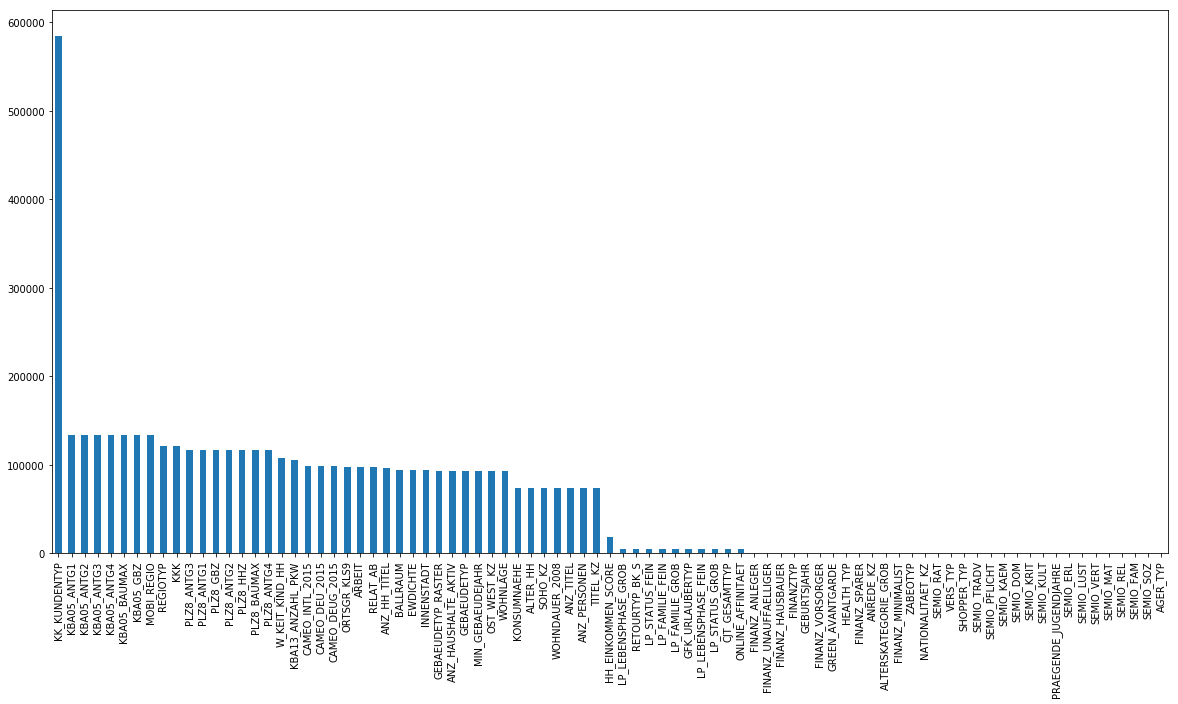

In [6]:
# checking NaN's in data before conversion
azdias.isnull().sum().sort_values(ascending=False).plot.bar(figsize=(20,10))

In [7]:
def check_and_convert_missing_to_nan(feat_info,azdias):
    for i,j in enumerate(feat_info['attribute']):
        #print(i,j)
        unknowns = feat_info['missing_or_unknown'][i][1:-1].split(",")
        if unknowns != [''] :
            x_lst=['X','XX']
            replace = [int(k) if k not in x_lst else k  for k in unknowns ] 
            azdias[j] = azdias[j].replace(replace,np.nan)
        
check_and_convert_missing_to_nan(feat_info,azdias) 

In [8]:
azdias.isnull().mean().sort_values(ascending=False)

TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
REGIOTYP                 0.177357
KKK                      0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
PLZ8_ANTG1               0.130736
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
SHOPPER_TYP              0.124768
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_AKTIV      0.111769
CAMEO_INTL_201

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

print("Total Missing data after conversion: ", azdias.isnull().sum().sum())
print("Column wise missing data after con : \n", azdias.isnull().sum().sort_values(ascending=False))

Total Missing data after conversion:  8373929
Column wise missing data after con : 
 TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV

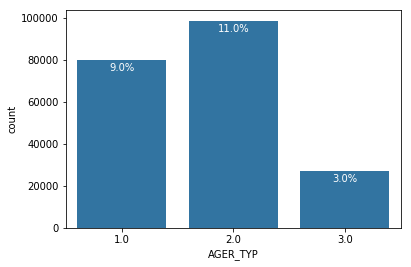

In [10]:
# create the plot for one column
base_color = sns.color_palette()[0]

sns.countplot(data = azdias, x = 'AGER_TYP', color = base_color)

# add annotations
n_points = azdias.shape[0]
cat_counts = azdias['AGER_TYP'].value_counts(dropna=False)
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):
    #print(loc,label.get_text())
    # get the text property for the label to get the correct count
    count = cat_counts[float(label.get_text())]
    #print(count,n_points)
    pct_string = '{:0.1f}%'.format(100*count/n_points)
    #print(pct_string)
    # print the annotation just below the top of the bar
    plt.text(loc, count-5000, pct_string, ha = 'center',color='w')

In [11]:
def plot_col(ax,col_name):
    base_color = sns.color_palette()[0]

    sns.countplot(data = azdias, x = col_name, color = base_color)

    # add annotations
    n_points = azdias.shape[0]
    cat_counts = azdias[col_name].value_counts(dropna=False)
    #print(cat_counts[1.0])
    locs, labels = plt.xticks() # get the current tick locations and labels

    # loop through each pair of locations and labels
    for loc, label in zip(locs, labels):
        #print(loc,label.get_text())
        # get the text property for the label to get the correct count
        count = cat_counts[float(label.get_text())]
        #print(count,n_points)
        pct_string = '{:0.1f}%'.format(100*count/n_points)
        #print(pct_string)
        # print the annotation just below the top of the bar
        ax.text(loc, count, pct_string, ha = 'center',color='r')

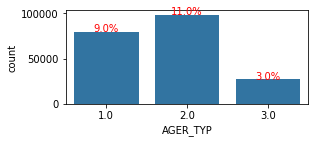

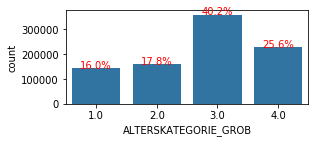

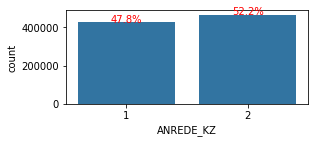

In [12]:
for i in range(0,3):
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot(5,4,1+i)
    plot_col(ax,azdias.columns[i])
    
    

In [13]:
def text_plot(ax,cat_counts,count):
    n_points = azdias.shape[0]
    locs, labels = plt.xticks() # get the current tick locations and labels

    # loop through each pair of locations and labels
    for loc, label in zip(locs, labels):
        #print(loc,label.get_text())
        # get the text property for the label to get the correct count
        count = cat_counts[loc]
        #print(count)
        #print(count,n_points)
        per = 100*count/n_points
        if per >= 34:
            print(label.get_text())
        pct_string = '{:0.1f}%'.format(per)
        #print(pct_string)
        # print the annotation just below the top of the bar
        ax.text(loc, count, pct_string, ha = 'center',color='r')

AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
KBA05_BAUMAX


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

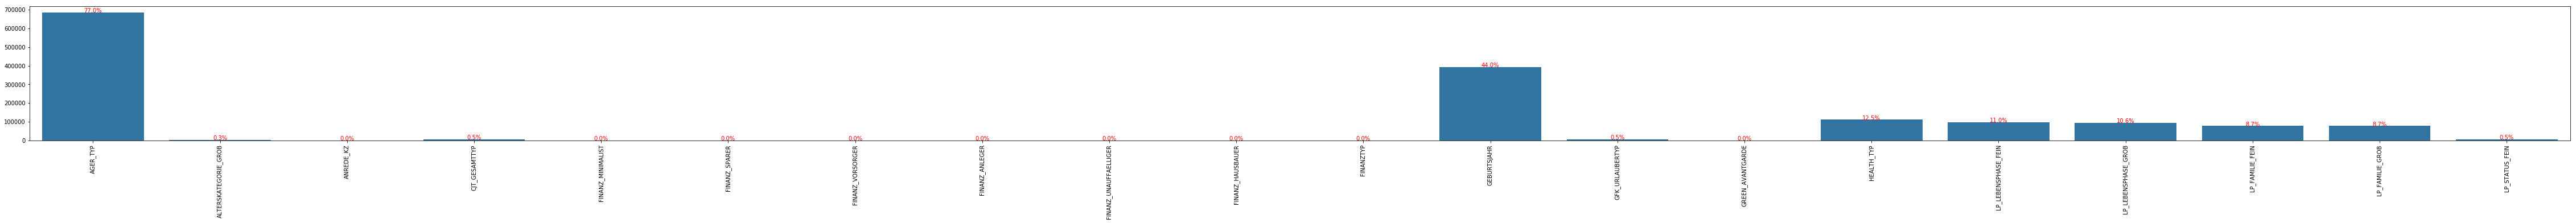

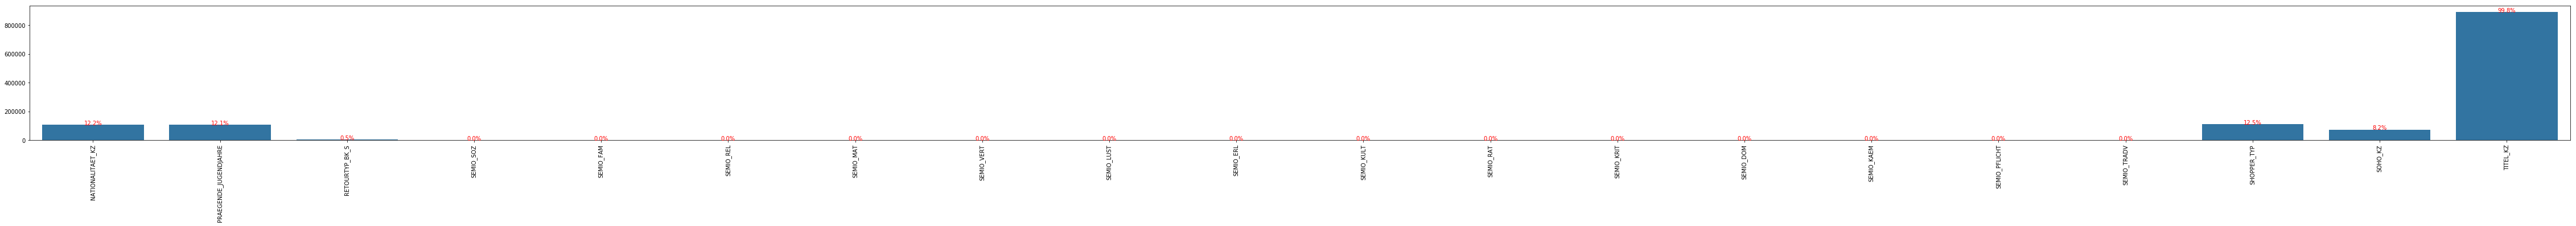

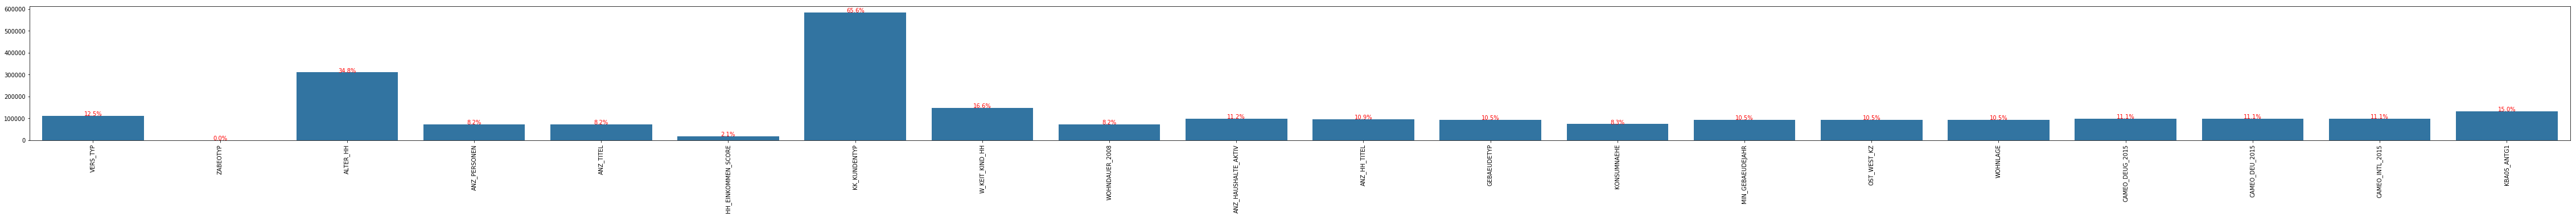

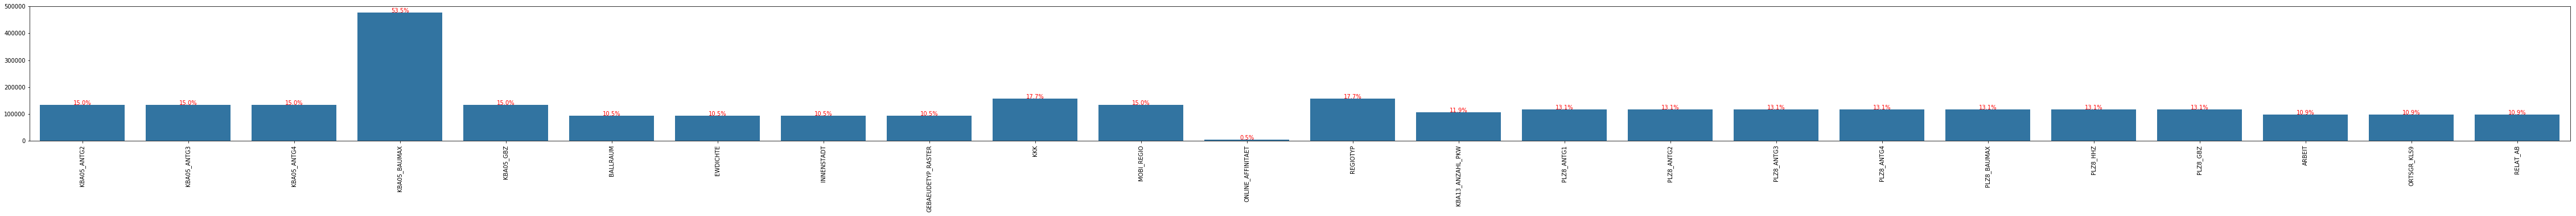

In [14]:
# Investigate patterns in the amount of missing data in each column.

na_counts = azdias.isnull().sum()
#print(na_counts.index.values)
base_color = sns.color_palette()[0]

fig =plt.figure(1,figsize=[80,20])

ax = plt.subplot(4, 1, 1)
sns.barplot(na_counts.index.values[:20],na_counts[:20],color=base_color)
text_plot(ax,na_counts[:20],count)
plt.xticks(rotation=90)

fig =plt.figure(2,figsize=[80,20])
ax2 = plt.subplot(4, 1, 2)
sns.barplot(na_counts.index.values[21:41],na_counts[21:41],color=base_color)
text_plot(ax2,na_counts[21:41],count)
plt.xticks(rotation=90)

fig =plt.figure(3,figsize=[80,20])
ax3 = plt.subplot(4, 1, 3)
sns.barplot(na_counts.index.values[41:61],na_counts[41:61],color=base_color)
text_plot(ax3,na_counts[41:61],count)
plt.xticks(rotation=90)

fig =plt.figure(4,figsize=[80,20])
ax4 = plt.subplot(4, 1, 4)
sns.barplot(na_counts.index.values[61:],na_counts[61:],color=base_color)
text_plot(ax4,na_counts[61:],count)
plt.xticks(rotation=90)



In [15]:
(azdias.isnull().sum()/azdias.shape[0]*100).sort_values(ascending=False)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

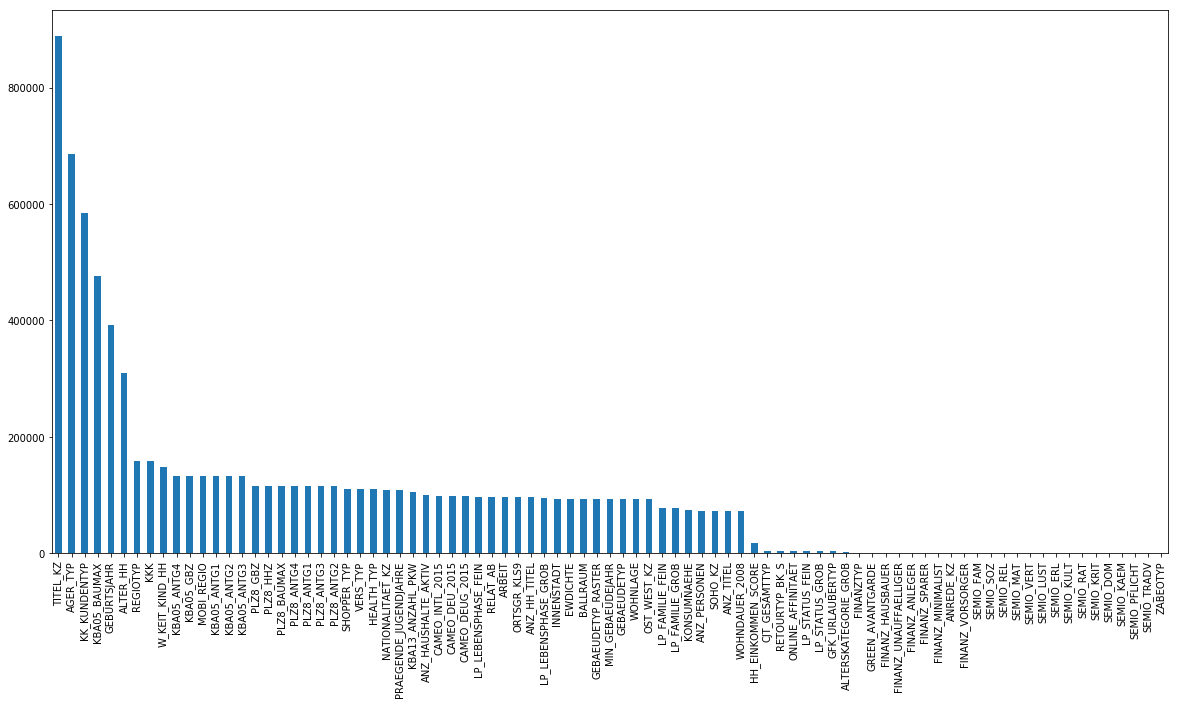

In [16]:
# after converting to missing values to NAN
azdias.isnull().sum().sort_values(ascending=False).plot.bar(figsize=(20,10))

person            43
macrocell_plz8     8
household          7
building           7
microcell_rr3      6
region_rr1         5
postcode           3
microcell_rr4      3
community          3
Name: information_level, dtype: int64


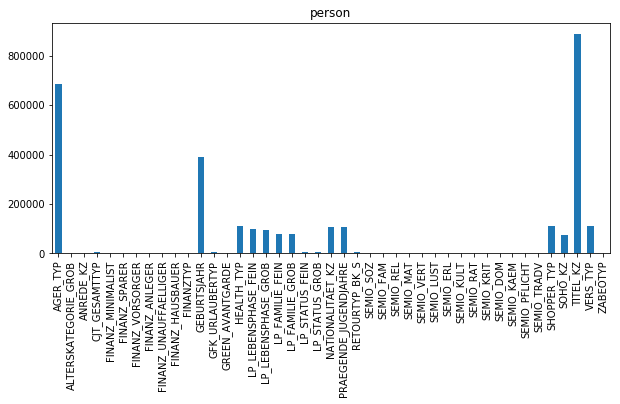

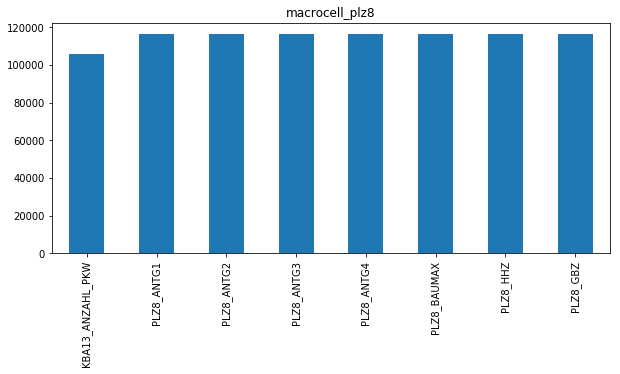

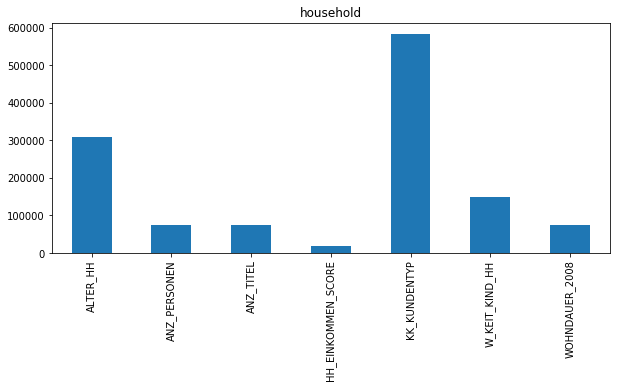

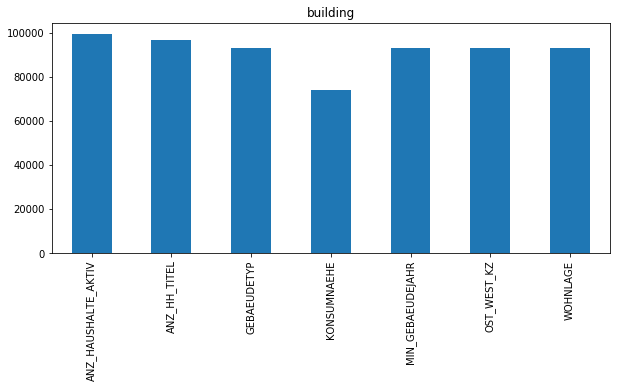

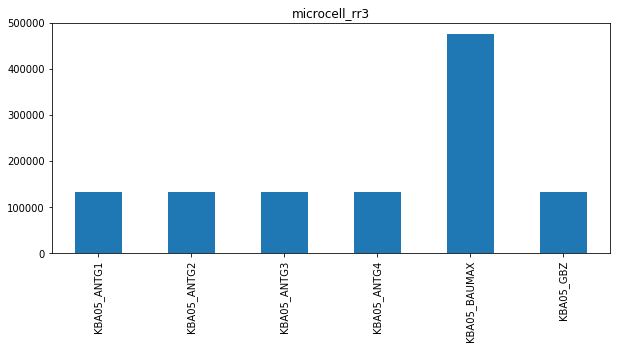

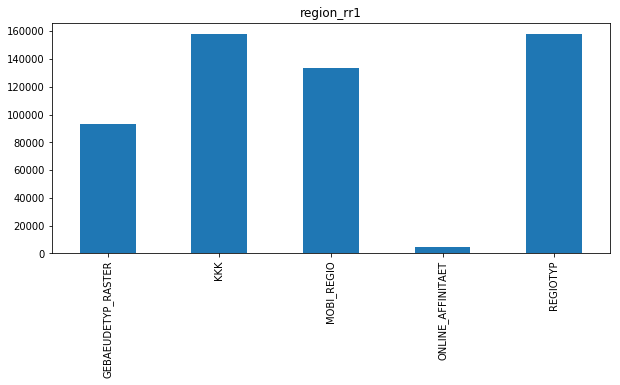

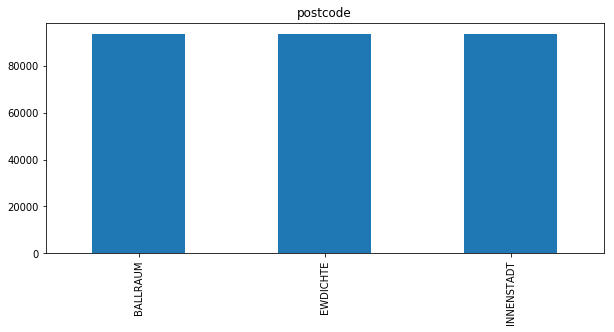

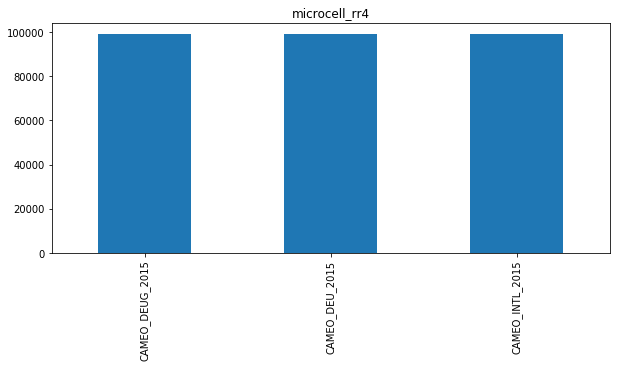

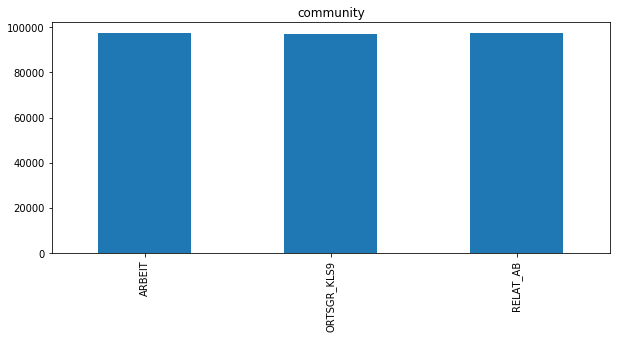

In [17]:
#plotting informational_level missing data
level = feat_info.information_level.value_counts()
print(level)

for i in range(0,len(level)):
    
    fig = plt.figure(i,figsize=(10,50))
    fig.tight_layout()
    
    lx = plt.subplot(10,1,i+1)
    
    criteria = feat_info['information_level'] == level.index[i]

    macro = feat_info.loc[criteria]['attribute']

    azdias[macro].isnull().sum().plot.bar()
    plt.title(level.index[i])


In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

per_cols = (azdias.isnull().sum()/azdias.shape[0]*100).sort_values(ascending=False)

#removing columns having more than 25% data missing
#remove_cols = [i for i,j in zip(per_cols.index,per_cols.values) if j > 25]
remove_cols = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
#remove_cols = ['NATIONALITAET_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'VERS_TYP', 'ANREDE_KZ',
#          'GEBURTSJAHR', 'SHOPPER_TYP', 'HEALTH_TYP', 'FINANZ_SPARER']
print(remove_cols)
azdias = azdias.drop(remove_cols,axis=1)
print("Total missing data after removing outliers:",azdias.isnull().sum().sum())
print("Shape of Data after removing outliers : ",azdias.shape)


['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
Total missing data after removing outliers: 5035304
Shape of Data after removing outliers :  (891221, 79)


In [19]:
azdias.isnull().sum().sum()

5035304

#### Discussion 1.1.2: Assess Missing Data in Each Column

Assessing column wise data in azdias:
* A total of 4,896,838 data points are NaN in the original data(891221*85) which is 6.46% and 8,373,929 data points are NaN after converting missing values to NaN which is 11.05%.
* Columns TITEL_KZ (99.75%), AGER_TYP (76.9%), KK_KUNDENTYP (65.5%), KBA05_BAUMAX (53.4%), GEBURTSJAHR(44.0%) and  ALTER_HH (34.8%)are missing more than 30% of data.  
* And another observation at inforamation_level type, 'person','household',microcell_rr3 are the three categories which are more than 3,00,000 data missing and rest of the categories have same amount of data (which is less than 3,00,000) missing.
* Most of the columns are dropped from these 3 categories 'person','household' and microcell_rr3 which will have less impact and these are having high percentage of data loss.
* And the columns dropped have more than 30% of data is missing in those columns.
* And the dropped columns are ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
* A total of 5,035,304 data ponts are missing after removing columns which is 6.64%. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?
print(azdias.isnull().sum(axis = 1).sum())
print(azdias.isnull().sum(axis = 1))

5035304
0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64


In [21]:
missing_rows = azdias.isnull().sum(axis=1)
print(missing_rows.value_counts().sort_index())
missing_rows_per = missing_rows[missing_rows > 0]/(len(azdias.columns)) * 100
print(missing_rows_per.sort_values(ascending=False))


0     623209
1      15738
2      27926
3      17629
4      12607
5      22515
6      13771
7      13714
8      24592
9       3042
10      5410
11      1127
12       766
13      3255
14      2243
15      4743
16      2505
17       677
18       428
19      1180
20       349
21       150
22       129
23       132
24        69
25        55
26        59
27        24
28         5
29        12
30         6
31         3
32       206
33      2985
34     10816
35      3911
36        84
37       538
38       421
39        77
40       137
41       356
42        21
43     27369
44       155
45       494
47     45578
48         1
49         2
dtype: int64
732775    62.025316
643174    62.025316
472919    60.759494
604334    59.493671
604314    59.493671
768879    59.493671
604319    59.493671
604322    59.493671
604323    59.493671
275622    59.493671
62901     59.493671
275620    59.493671
604332    59.493671
275617    59.493671
604305    59.493671
275611    59.493671
275610    59.493671
62912     

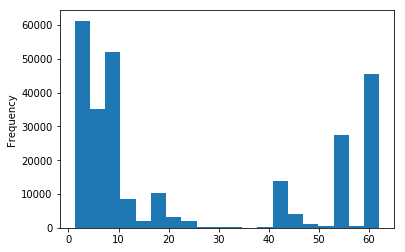

In [22]:
missing_rows_per.plot.hist(bins=20)

In [23]:
for i in range(1,15):
    lst_n_miss_rows = azdias[missing_rows < i].reset_index(drop=True)
    grt_n_miss_rows = azdias[missing_rows >= i].reset_index(drop=True)
    lst_n_count = lst_n_miss_rows.shape[0]
    grt_n_count = grt_n_miss_rows.shape[0]
    l_coverage =  (lst_n_miss_rows.shape[0] /azdias.shape[0])* 100
    g_coverage = (grt_n_miss_rows.shape[0] /azdias.shape[0])* 100
    print("For ", i," missing values ","l_coverage : ",l_coverage, " g_coverage :", g_coverage)

For  1  missing values  l_coverage :  69.9275488346886  g_coverage : 30.07245116531141
For  2  missing values  l_coverage :  71.69344079639058  g_coverage : 28.30655920360943
For  3  missing values  l_coverage :  74.82689478816141  g_coverage : 25.173105211838593
For  4  missing values  l_coverage :  76.80496756696712  g_coverage : 23.195032433032882
For  5  missing values  l_coverage :  78.21954374953015  g_coverage : 21.78045625046986
For  6  missing values  l_coverage :  80.74585316100047  g_coverage : 19.25414683899953
For  7  missing values  l_coverage :  82.29103667889333  g_coverage : 17.708963321106662
For  8  missing values  l_coverage :  83.82982447675717  g_coverage : 16.170175523242833
For  9  missing values  l_coverage :  86.5891849496365  g_coverage : 13.410815050363489
For  10  missing values  l_coverage :  86.930514429081  g_coverage : 13.069485570918998
For  11  missing values  l_coverage :  87.53754680376696  g_coverage : 12.462453196233033
For  12  missing values  l_

In [24]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
#Selected 9 missing row so that it covers about 86% of data
low_miss_rows = azdias[missing_rows < 10].reset_index(drop=True)
more_miss_rows = azdias[missing_rows >= 10].reset_index(drop=True)

display(low_miss_rows.head())
display(more_miss_rows.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
3,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
4,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,2,4.0,4,3,1,4,5,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,1.0


In [25]:
display(low_miss_rows.shape)
display(more_miss_rows.shape)

(774743, 79)

(116478, 79)

In [26]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
cols = azdias.columns
def dist_cmp_plot(cols):
    
    for i in range(0,len(cols)):
        
        fig = plt.figure(i,figsize=(8,4))
        fig.subplots_adjust(wspace=1)
        
        ax = plt.subplot(1,2,1)
        sns.countplot(low_miss_rows[cols[i]],ax = ax)
        ax.set_title("low_miss_rows") 
        
        ax2 = plt.subplot(1,2,2)
        sns.countplot(more_miss_rows[cols[i]],ax=ax2)
        ax2.set_title("more_miss_rows")
  

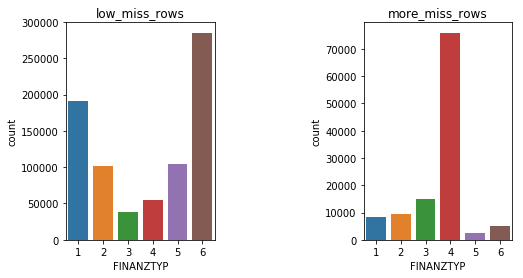

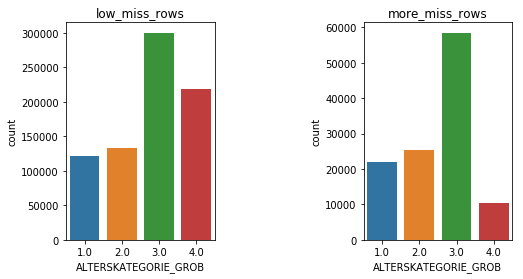

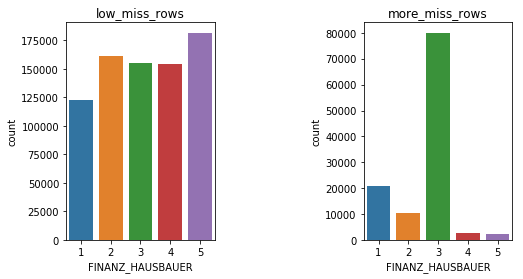

In [27]:
#plotting for more miss data columns
more_cols = ['FINANZTYP','ALTERSKATEGORIE_GROB', 'FINANZ_HAUSBAUER']
dist_cmp_plot(more_cols) 

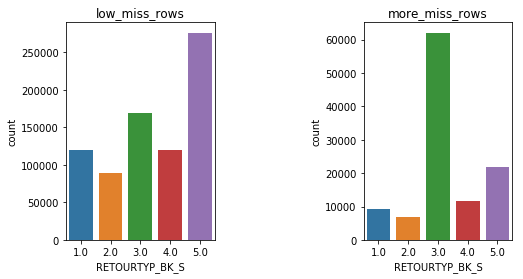

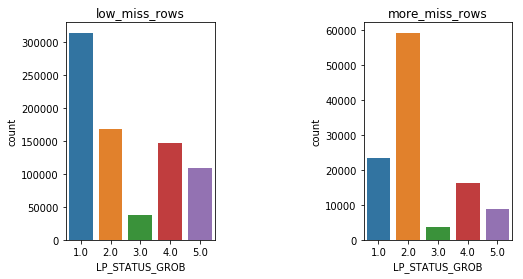

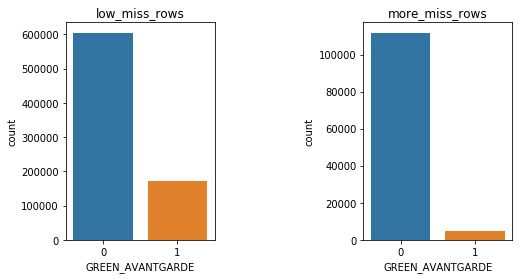

In [28]:
#plotting for less data miss columns
less_cols = ['RETOURTYP_BK_S','LP_STATUS_GROB','GREEN_AVANTGARDE']
dist_cmp_plot(less_cols)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Assesing row wise data:
* A total of 8,91,221 are present in which 623209 are the rows without any missing values and 15738 are missing one value. 
* And if we observe from 5 missing values to 10 missing values:
    * For  5  missing values  l_coverage :  78.21954374953015  g_coverage : 21.78045625046986
    * For  6  missing values  l_coverage :  80.74585316100047  g_coverage : 19.25414683899953
    * For  7  missing values  l_coverage :  82.29103667889333  g_coverage : 17.708963321106662
    * For  8  missing values  l_coverage :  83.82982447675717  g_coverage : 16.170175523242833
    * For  9  missing values  l_coverage :  86.5891849496365  g_coverage : 13.410815050363489
    * For  10  missing values  l_coverage :  86.930514429081  g_coverage : 13.069485570918998
    
* From above we can see if we take less than 5 value missing data we can cover 78% data of original.
* Here we have two options either to take less missing values or more missing rows and fill them with some value.
* So, have taken 9 missing values which will cover 86% data.
* And also observed, data with many missing values looks very different from the data with few or no missing values. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [29]:
# How many features are there of each data type?
display(feat_info.head())
display(feat_info.type.value_counts())

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
#display(feat_info[feat_info.type == 'categorical']['attribute'])
categorical_cols = feat_info[feat_info.type == 'categorical']['attribute']

#eliminating already removed columns
cat_cols = [x for x in categorical_cols  if x in low_miss_rows.columns]
print("Length of categorical_columns :",len(cat_cols))
print(cat_cols)


Length of categorical_columns : 18
['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [31]:
binary_cat = [ i for i in cat_cols if len(low_miss_rows[i].unique()) <= 2]
print(binary_cat)
for i in binary_cat:
    display(low_miss_rows[i].unique())
             

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']


array([2, 1])

array([0, 1])

array([ 1.,  0.])

array(['W', 'O'], dtype=object)

In [32]:
print(low_miss_rows['OST_WEST_KZ'].value_counts())
low_miss_rows['OST_WEST_KZ'] = low_miss_rows['OST_WEST_KZ'].map({'W':0,'O':1})
print(low_miss_rows['OST_WEST_KZ'].value_counts())

W    610258
O    164485
Name: OST_WEST_KZ, dtype: int64
0    610258
1    164485
Name: OST_WEST_KZ, dtype: int64


In [33]:
multi_cat = [ i for i in cat_cols if len(low_miss_rows[i].unique()) > 2]
print(multi_cat)
for i in multi_cat:
    display(low_miss_rows[i].unique())

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


array([ 5.,  3.,  2.,  4.,  1.,  6.])

array([1, 6, 5, 2, 4, 3])

array([ 10.,   1.,   5.,  12.,   9.,   3.,   8.,  11.,   4.,   7.,   2.,
         6.])

array([  5.,   1.,  nan,  10.,   2.,   7.,  11.,   8.,   4.,   6.,   9.,
         3.])

array([  3.,   1.,  nan,   5.,   2.,   4.])

array([  2.,   3.,   9.,   4.,   1.,  10.,   5.,   8.,   6.,   7.])

array([ 1.,  2.,  4.,  5.,  3.])

array([  1.,   3.,   2.,  nan])

array([  3.,   2.,   1.,   0.,  nan])

array([  2.,   1.,  nan])

array([5, 3, 4, 1, 6, 2])

array([ 8.,  1.,  3.,  2.,  6.,  4.,  5.])

array(['8', '4', '2', '6', '1', '9', '5', '7', '3', nan], dtype=object)

array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C',
       '8B', '7A', '5D', '9E', '9B', '1B', '3D', nan, '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

In [34]:
# Re-encode categorical variable(s) to be kept in the analysis.

#multi_cat_add = [ i for i in cat_cols if (len(lst_7_miss_rows[i].unique()) > 2) and (len(lst_7_miss_rows[i].unique()) < 7)]
#multi_cat_add = ['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'TITEL_KZ', 'ZABEOTYP']
#print(multi_cat_add)

#multi_cat_drop  = [ i for i in cat_cols if len(lst_7_miss_rows[i].unique()) >= 7]
#multi_cat_drop = ['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'GEBAEUDETYP',
#                  'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
#print(multi_cat_drop)


In [35]:
#dropping all multi more than or equal 7 
#lst_7_miss_rows = lst_7_miss_rows.drop(multi_cat_drop,axis=1)
#display(lst_7_miss_rows.head())

In [36]:
#Encoding
#lst_7_miss_rows = pd.get_dummies(lst_7_miss_rows,columns=multi_cat_add)
#display(lst_7_miss_rows.head())

In [37]:
#dropping all multi-var columns 
multi_cat = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 
             'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
             'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
low_miss_rows = low_miss_rows.drop(multi_cat,axis=1)
display(low_miss_rows.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
3,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
4,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features

* A total of 21 categorical and 7 mixed coulmns are present in feat_info data
* But we have already deleted some columns, so a total of 18 categorical columns are only present after colums and row wise data assession.
* Out of 18 a total of 4 binary and 14 multi category columns are present.
* Binary cat columns are ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
* And in  binary, a column 'OST_WEST_KZ' is having a non numerical values [W,O] and it has been converted into [0,1]
* And i have tried to encode multi category size less than 7 and dropped the multi-category level higher than 7.
* Multi category columsn are encoded to different number of columns in Demographic data and Customer data(Column szies are diffrent for both demographic and customer after using one hot encoding. 
* So, dropped all multi-cat columns for simplicity and below is the list
    * ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB','LP_STATUS_FEIN',
    'LP_STATUS_GROB', 'NATIONALITAET_KZ','SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [38]:
mixed_cols = feat_info[feat_info.type == 'mixed']['attribute']
print(mixed_cols)
mixed_cols = [i  for i in mixed_cols if i in low_miss_rows.columns]
print(mixed_cols)
for i in mixed_cols:
    #display(azdias[i].value_counts(dropna=False))
    pass

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object
['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [39]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

display(low_miss_rows.PRAEGENDE_JUGENDJAHRE.value_counts().sort_values())

low_miss_rows['MOVEMENT'] = low_miss_rows['PRAEGENDE_JUGENDJAHRE'].map(lambda x: 0 if x in (2,4,6,7,9,11,13,15) else 1)

low_miss_rows['GEN_BY_DEC'] = low_miss_rows['PRAEGENDE_JUGENDJAHRE'].map(lambda x: 1 if x in (1,2) else (
    2 if x in (3,4) else (
        3 if x in (5,6,7) else (
            4 if x in (8,9) else(
                5 if x in (10,11,12,13) else 6)))) )


7.0       3939
13.0      5520
2.0       7387
1.0      20106
4.0      20185
12.0     23925
6.0      25311
9.0      32939
11.0     34385
15.0     40803
3.0      52758
5.0      83112
10.0     83394
8.0     137903
14.0    177574
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [40]:
display(low_miss_rows.head())
display(low_miss_rows.MOVEMENT.value_counts().sort_values())
display(low_miss_rows.GEN_BY_DEC.value_counts().sort_values())
#low_miss_rows.drop('PRAEGENDE_JUGENDJAHRE',axis =1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,GEN_BY_DEC
0,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1,6
1,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,6
2,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1,4
3,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1,4
4,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1,2


0    170469
1    604274
Name: MOVEMENT, dtype: int64

1     27493
2     72943
3    112362
5    147224
4    170842
6    243879
Name: GEN_BY_DEC, dtype: int64

In [41]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

display(low_miss_rows.CAMEO_INTL_2015.value_counts(dropna=False))

low_miss_rows['WEALTH'] = low_miss_rows['CAMEO_INTL_2015'].map(lambda x: int(x)//10 if x is not np.nan else np.nan)
low_miss_rows['LIFE_STAGE'] = low_miss_rows['CAMEO_INTL_2015'].map(lambda x: int(x)%10 if x is not np.nan else np.nan)


51     132086
41      90430
24      88559
14      60994
43      55429
54      44745
25      38587
22      31990
45      25610
13      25477
23      24111
55      23440
52      20258
34      18111
31      17721
15      16645
44      14502
12      12795
35      10139
32      10087
33       9571
NaN      3456
Name: CAMEO_INTL_2015, dtype: int64

In [42]:
display(low_miss_rows.head())
display(low_miss_rows.WEALTH.value_counts())
display(low_miss_rows.LIFE_STAGE.value_counts().sort_values())
#low_miss_rows.drop('CAMEO_INTL_2015',axis =1,inplace=True )

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,GEN_BY_DEC,WEALTH,LIFE_STAGE
0,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1,6,5.0,1.0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,0,6,2.0,4.0
2,4.0,2,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,1,4,1.0,2.0
3,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,1,4,4.0,3.0
4,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1,2,5.0,4.0


5.0    220529
4.0    185971
2.0    183247
1.0    115911
3.0     65629
Name: WEALTH, dtype: int64

2.0     75130
5.0    114421
3.0    114588
4.0    226911
1.0    240237
Name: LIFE_STAGE, dtype: int64

In [43]:
# drop mixed columns mixed_cols
low_miss_rows = low_miss_rows.drop(mixed_cols,axis=1)
low_miss_rows.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,GEN_BY_DEC,WEALTH,LIFE_STAGE
0,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1,6,5.0,1.0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,0,6,2.0,4.0
2,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,1,4,1.0,2.0
3,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,1,4,4.0,3.0
4,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1,2,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

* There are 7 mixed type features.And One column out 7 already dropped as an outier.
* I have re-engineered columns PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 and deleted all other mixed type columns.
* Column PRAEGENDE_JUGENDJAHRE was derived into two columns MOVEMENT and GEN_BY_DESC columns.
    * MOVEMENT was ecoded to 0(Main Stream) and 1(Avantgarde)
    * GEN_BY_DESC was encode as 1,2,3,4,5,6 for generations from 40's to 90's.
* Column CAMEO_INTL_2015 was derived into  WEALTH and LIFE_STAGE columns.
    * WEALTH was encode as 1,2,3,4,5 (1 -- as the walthy person and 5 -- as the poor person)
    * LIFE_STAGE was encode as 1,2,3,4,5 (1 -- as single and 5 -- as elders )

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [44]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
display(low_miss_rows.describe())
display(low_miss_rows.shape)
display(low_miss_rows.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,GEN_BY_DEC,WEALTH,LIFE_STAGE
count,772147.000000,774743.000000,774743.000000,774743.000000,774743.000000,774743.000000,774743.000000,774743.000000,774743.000000,741323.000000,...,766960.000000,766960.000000,766960.000000,770807.000000,770893.000000,770807.000000,774743.000000,774743.000000,771287.000000,771287.000000
mean,2.796903,1.521221,3.050652,2.710942,3.438778,2.837575,2.633012,3.144132,0.220033,2.203911,...,0.699986,3.612779,3.379818,3.174345,5.306886,3.079348,0.779967,4.379810,3.274813,2.870540
std,1.019782,0.499550,1.377400,1.486386,1.377239,1.472501,1.393403,1.398325,0.414269,0.755091,...,0.727384,0.973575,1.111673,0.996905,2.302338,1.359219,0.414269,1.464903,1.465608,1.488003
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,0.000000,3.000000,3.000000,3.000000,4.000000,2.000000,1.000000,3.000000,2.000000,1.000000
50%,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000,1.000000,5.000000,4.000000,3.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000,1.000000,6.000000,5.000000,4.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,2.000000,5.000000,5.000000,5.000000,9.000000,5.000000,1.000000,6.000000,5.000000,5.000000


(774743, 63)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,GEN_BY_DEC,WEALTH,LIFE_STAGE
0,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1,6,5.0,1.0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,0,6,2.0,4.0
2,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,1,4,1.0,2.0
3,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,1,4,4.0,3.0
4,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1,2,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [45]:
#clean function for the data
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...        
    for i,j in enumerate(feat_info['attribute']):
        #print(i,j)
        unknowns = feat_info['missing_or_unknown'][i][1:-1].split(",")
        if unknowns != ['']:
            x_lst=['X','XX']
            replace = [int(k) if k not in x_lst else k  for k in unknowns]
            df[j] = df[j].replace(replace,np.nan)
        
    # remove selected columns and rows, ...
    #remove_cols = [i for i,j in zip(per_cols.index,per_cols.values) if j > 25]
    remove_cols = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    print("Columns to remove :",remove_cols)
    df = df.drop(remove_cols,axis=1)
    print("Shape after dropping more missing data cols:",df.shape)
    
    #print("After dropping columns",df.columns)
    missing_rows = df.isnull().sum(axis=1)
    low_miss_rows = df[missing_rows < 10].reset_index(drop=True)
    more_miss_rows = df[missing_rows >= 10].reset_index(drop=True)
    
    # select, re-encode, and engineer column values.
    #encode binary category having non numeric value
    low_miss_rows['OST_WEST_KZ'] = low_miss_rows['OST_WEST_KZ'].map({'W':0,'O':1})
    
    multi_cat = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 
             'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
             'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    
    low_miss_rows = low_miss_rows.drop(multi_cat,axis=1)
    
    print("Shape after dropping multi-cols: ",low_miss_rows.shape)

    #mixed_cols = feat_info[feat_info.type == 'mixed']['attribute']
    mixed_cols = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']
    #print(mixed_cols)
    low_miss_rows['MOVEMENT'] = low_miss_rows['PRAEGENDE_JUGENDJAHRE'].map(lambda x: 0 if x in (2,4,6,7,9,11,13,15) else 1)

    low_miss_rows['GEN_BY_DEC'] = low_miss_rows['PRAEGENDE_JUGENDJAHRE'].map(lambda x: 1 if x in (1,2) else (
        2 if x in (3,4) else (
            3 if x in (5,6,7) else (
                4 if x in (8,9) else(
                    5 if x in (10,11,12,13) else 6)))) )

    low_miss_rows['WEALTH'] = low_miss_rows['CAMEO_INTL_2015'].map(lambda x: int(x)//10 if x is not np.nan else np.nan)
    low_miss_rows['LIFE_STAGE'] = low_miss_rows['CAMEO_INTL_2015'].map(lambda x: int(x)%10 if x is not np.nan else np.nan)
    low_miss_rows = low_miss_rows.drop(mixed_cols,axis=1)
    
    # Return the cleaned dataframe.
    print("Shape of clean data :",low_miss_rows.shape)
    display(low_miss_rows.head())
    return low_miss_rows,more_miss_rows


### Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [46]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias1 = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=";")
df_clean_data,gen_more_miss_data = clean_data(azdias1)


Columns to remove : ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
Shape after dropping more missing data cols: (891221, 79)
Shape after dropping multi-cols:  (774743, 65)
Shape of clean data : (774743, 63)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,GEN_BY_DEC,WEALTH,LIFE_STAGE
0,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1,6,5.0,1.0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,0,6,2.0,4.0
2,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,1,4,1.0,2.0
3,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,1,4,4.0,3.0
4,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1,2,5.0,4.0


In [47]:
#Imputing data
imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
df_transform = imputer.fit_transform(df_clean_data)
df_transform = pd.DataFrame(df_transform,columns = df_clean_data.columns)
display(df_transform.head())
print("Any NaN : ",df_transform.isnull().any().any())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,GEN_BY_DEC,WEALTH,LIFE_STAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1.0,6.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,0.0,6.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,1.0,4.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,1.0,4.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1.0,2.0,5.0,4.0


Any NaN :  False


In [48]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_transform)
df_scaled = pd.DataFrame(df_scaled,columns=df_transform.columns)
display(df_scaled.shape)
display(df_scaled.head())


(774743, 63)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,GEN_BY_DEC,WEALTH,LIFE_STAGE
0,-1.765558,0.958422,-1.488785,1.540017,-1.044684,1.468541,0.981043,1.327209,-0.531136,1.007436,...,0.422301,1.435587,0.563825,-0.179238,-0.132956,0.679358,0.531136,1.106006,1.170872,-1.249876
1,0.198811,0.958422,-1.488785,0.867244,-1.770775,-0.568811,0.263375,1.327209,1.882757,1.007436,...,-0.953065,0.405294,0.563825,-0.179238,-0.132956,-0.795816,-1.882757,1.106006,-0.874330,0.763676
2,1.180995,0.958422,0.689233,-0.478302,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.315096,...,-0.953065,-0.625000,0.563825,-1.183153,-1.003767,-0.058229,0.531136,-0.259273,-1.556065,-0.578692
3,0.198811,-1.043381,0.689233,0.194471,0.407498,-1.247929,0.263375,-0.818216,-0.531136,1.007436,...,0.422301,-0.625000,-0.339744,0.824677,0.302450,1.416945,0.531136,-0.259273,0.489138,0.092492
4,-1.765558,0.958422,-0.036773,-1.151076,1.133590,-0.568811,-0.454293,1.327209,-0.531136,1.007436,...,0.422301,1.435587,1.467394,-1.183153,-1.003767,-0.058229,0.531136,-1.624552,1.170872,0.763676


In [49]:
df_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,GEN_BY_DEC,WEALTH,LIFE_STAGE
count,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,...,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05
mean,4.053730e-17,-3.738236e-17,-1.041864e-16,8.767796e-17,4.510462e-17,1.162742e-16,-3.250321e-17,1.707152e-16,6.704246e-17,7.058259e-17,...,-1.010681e-17,-7.744275e-17,1.652308e-16,-1.581138e-16,-4.423335e-17,4.396279e-17,7.041751e-17,-1.779239e-16,4.593004e-17,-6.645549e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.765558e+00,-1.043381e+00,-1.488785e+00,-1.151076e+00,-1.770775e+00,-1.247929e+00,-1.171961e+00,-1.533358e+00,-5.311360e-01,-1.637628e+00,...,-9.530651e-01,-2.685586e+00,-2.146882e+00,-2.187068e+00,-1.874578e+00,-1.533403e+00,-1.882757e+00,-2.307192e+00,-1.556065e+00,-1.249876e+00
25%,-7.833737e-01,-1.043381e+00,-7.627794e-01,-1.151076e+00,-1.044684e+00,-1.247929e+00,-1.171961e+00,-8.182165e-01,-5.311360e-01,-3.150957e-01,...,-9.530651e-01,-6.249996e-01,-3.397439e-01,-1.792382e-01,-5.683612e-01,-7.958157e-01,5.311360e-01,-9.419128e-01,-8.743304e-01,-1.249876e+00
50%,1.988106e-01,9.584224e-01,-3.677339e-02,1.944708e-01,4.074985e-01,1.103059e-01,-4.542929e-01,-1.030746e-01,-5.311360e-01,-3.150957e-01,...,4.223012e-01,-6.249996e-01,-3.397439e-01,-1.792382e-01,-1.329557e-01,-5.822872e-02,5.311360e-01,4.233664e-01,4.891381e-01,9.249216e-02
75%,1.180995e+00,9.584224e-01,6.892326e-01,8.672441e-01,1.133590e+00,7.894232e-01,9.810433e-01,6.120673e-01,-5.311360e-01,1.007436e+00,...,4.223012e-01,4.052935e-01,5.638252e-01,8.246769e-01,7.378553e-01,6.793582e-01,5.311360e-01,1.106006e+00,1.170872e+00,7.636765e-01
max,1.180995e+00,9.584224e-01,1.415239e+00,1.540017e+00,1.133590e+00,1.468541e+00,1.698711e+00,1.327209e+00,1.882757e+00,1.007436e+00,...,1.797667e+00,1.435587e+00,1.467394e+00,1.828592e+00,1.608666e+00,1.416945e+00,5.311360e-01,1.106006e+00,1.170872e+00,1.434861e+00


### Discussion 2.1: Apply Feature Scaling

* Applied Imputer to fill NaN values with strategy 'most_frequent' to repeat frequent values.I have chosen this to achieve frequency, where mean and median will be out of the unique values of corresponding columns.
* And for scaling the data used StandardScaler.And after scaling we have achieved 0 mean and 1 standard deviation which would be perfect for PCA.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [50]:
# Apply PCA to the data.
def cal_pca(n_components,df):
    pca = PCA(n_components,random_state=99)
    df_pca = pca.fit_transform(df)
    return pca,df_pca

In [51]:
pca,df_pca = cal_pca(63,df_scaled)

In [52]:
# Investigate the variance accounted for by each principal component.
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
cumsum = np.cumsum(vals)
print("No. of components : ",num_components)

def find_nine_zero(ind,cumsum): 
    for i,j in zip(ind,cumsum):
        j = j*100
        print(i,j)
        if j > 90 and j < 91: 
            #print(i,j)
            pass


No. of components :  63


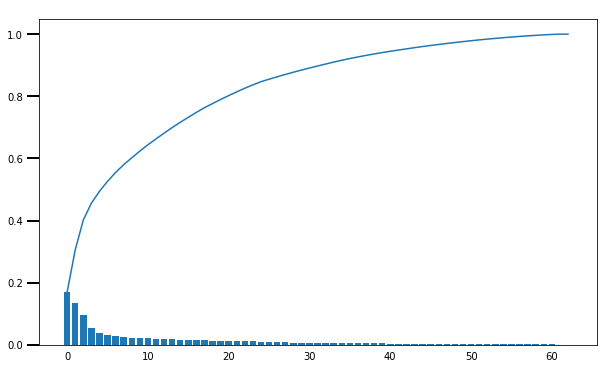

In [53]:
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
n_plot = 63
ax.bar(ind[:n_plot], vals[:n_plot])
ax.plot(ind[:n_plot], cumsum[:n_plot])
for i in range(n_plot):
    #ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
    pass    
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)    

In [54]:
for i,j in enumerate(cumsum):
    if i >= 0:
        print(i+1,j)

1 0.1702280551
2 0.305990123854
3 0.402055876694
4 0.455964795007
5 0.49407565442
6 0.526359394471
7 0.554871441001
8 0.579951425378
9 0.602117306284
10 0.623634943698
11 0.644060676901
12 0.662824212938
13 0.681396646922
14 0.69929474759
15 0.716262886971
16 0.732422888345
17 0.748288532423
18 0.763292336839
19 0.776630517057
20 0.789802540369
21 0.802331584795
22 0.814364267354
23 0.826049808831
24 0.836886210026
25 0.846986289161
26 0.855077140315
27 0.862754469514
28 0.870267674126
29 0.877543804713
30 0.884420587599
31 0.891032645399
32 0.897516458873
33 0.903926012448
34 0.910124699582
35 0.916038071518
36 0.921670374052
37 0.926709334855
38 0.931622303079
39 0.936299383179
40 0.94071266208
41 0.944884530914
42 0.948813739851
43 0.952704852944
44 0.956547962678
45 0.960159861102
46 0.963617228602
47 0.966915262697
48 0.970054189652
49 0.973111951721
50 0.976058888943
51 0.978839738241
52 0.981579250385
53 0.984114720083
54 0.986428574554
55 0.988698225874
56 0.990731885458
57 0.9

In [55]:
# Re-apply PCA to the data while selecting for number of components to retain.
#Slected 26 componets as it is covered almost 85% variance
pca,df_n_pca = cal_pca(26,df_scaled)

In [56]:
print(pca.components_.shape)
print(pca.explained_variance_ratio_.shape)
print(df_n_pca.shape)

(26, 63)
(26,)
(774743, 26)


### Discussion 2.2: Perform Dimensionality Reduction

* After applying PCA, by looking at the scree plot we can see that a minimum of 21 components are needed to achieve 80% cumulative variance.I have chosen 26 componenets as it is achieving 85% cumulative variance that means it can draw 26 dimension ellipsoid that covers 85% of data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [57]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def cal_weights(pca,num,df_columns,draw=False):
    dimensions = dimensions = ['Dimension{}'.format(i) for i in range(1,len(pca.components_)+1)]
    components = pd.DataFrame(np.round(pca.components_,4),columns=df_columns)
    components.index = dimensions
    #components.sort_values(by=1,inplace=True,ascending=False)
    
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    if draw: 
        fig = plt.figure(figsize=(20,10))
        fig.tight_layout()
        ax = plt.subplot(211)
        components.loc['Dimension{}'.format(num)].plot.bar(ax = ax);
        
    #return components.reset_index(drop=True)
    df_weight = pd.concat([variance_ratios, components], axis = 1)
    #df_weight.iloc[num].sort_values(ascending=False)
    return df_weight.loc['Dimension{}'.format(num)].sort_values(ascending=False)

def print_cal_weights(pca,num,df_columns,draw=False):
    wt1 = cal_weights(pca,num,df_columns,draw)
    display(wt1[:5])
    display(wt1[59:64])


PLZ8_ANTG3            0.2253
PLZ8_ANTG4            0.2175
WEALTH                0.2053
HH_EINKOMMEN_SCORE    0.2029
ORTSGR_KLS9           0.1961
Name: Dimension1, dtype: float64

KBA05_GBZ           -0.2158
KBA05_ANTG1         -0.2170
FINANZ_MINIMALIST   -0.2222
PLZ8_ANTG1          -0.2253
MOBI_REGIO          -0.2292
Name: Dimension1, dtype: float64

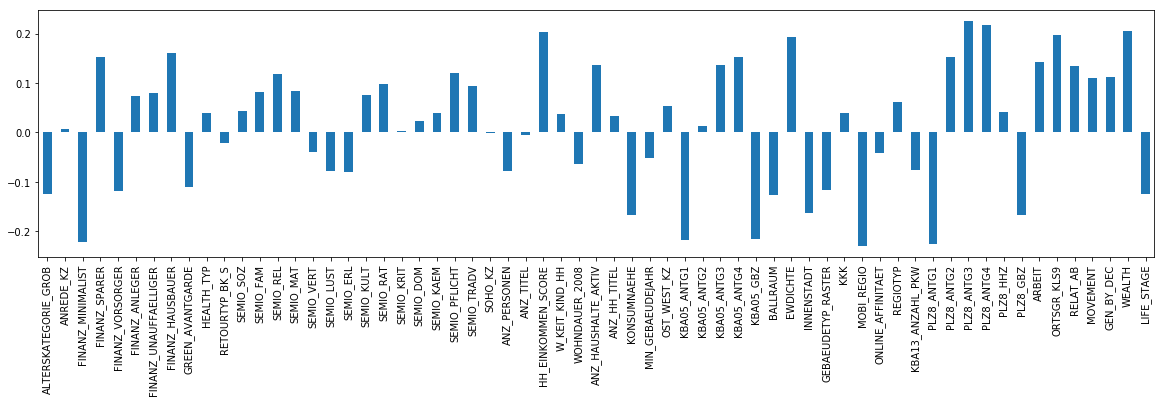

In [58]:
print_cal_weights(pca,1,df_scaled.columns,True)


In [59]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_cal_weights(pca,2,df_scaled.columns)


ALTERSKATEGORIE_GROB    0.2570
SEMIO_ERL               0.2302
FINANZ_VORSORGER        0.2293
SEMIO_LUST              0.1797
RETOURTYP_BK_S          0.1633
Name: Dimension2, dtype: float64

SEMIO_PFLICHT   -0.2272
SEMIO_TRADV     -0.2284
FINANZ_SPARER   -0.2323
GEN_BY_DEC      -0.2394
SEMIO_REL       -0.2547
Name: Dimension2, dtype: float64

In [60]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_cal_weights(pca,3,df_scaled.columns)

SEMIO_VERT           0.3460
SEMIO_SOZ            0.2628
SEMIO_FAM            0.2492
SEMIO_KULT           0.2329
FINANZ_MINIMALIST    0.1554
Name: Dimension3, dtype: float64

SEMIO_RAT    -0.2173
SEMIO_KRIT   -0.2734
SEMIO_DOM    -0.3131
SEMIO_KAEM   -0.3359
ANREDE_KZ    -0.3679
Name: Dimension3, dtype: float64

In [61]:
#Function to do cleaning,scaling 
def scaled_data(df):
    
    print("Imputing data")
    imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
    df_transform = imputer.fit_transform(df)
    df_transform = pd.DataFrame(df_transform,columns = df.columns)
    #df_transform.head()

    print("Scaling the data")
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_transform)
    df_scaled = pd.DataFrame(df_scaled,columns=df_transform.columns)
    display(df_scaled.head())
    print("Shape of scaled data:",df_scaled.shape)
    return imputer,scaler,df_scaled

def clean_scaled_data(df):
    print("Cleaning Data")
    df_clean,more_miss_data = clean_data(df)
    display(df_clean.head())

    print("Imputing data")
    imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
    df_transform = imputer.fit_transform(df_clean)
    df_transform = pd.DataFrame(df_transform,columns = df_clean.columns)
    #df_transform.head()

    print("Scaling the data")
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_transform)
    df_scaled = pd.DataFrame(df_scaled,columns=df_transform.columns)
    display(df_scaled.head())
    print("shape of clean_scaled_data : ",df_scaled.shape)
    return imputer,scaler,df_scaled,more_miss_data


In [62]:
#for quick conversion
#df_scaled = scaled_data(azdias)
#imputer,scaler,df_clean_scaled,more_miss_data = clean_scaled_data(azdias)

In [63]:
#for quick conversion
#pca,df_n_pca = cal_pca(29,df_clean_scaled)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)
After observing pricipal component weights we can conclude that
* For 1st principle component:
    * Top positive weights are PLZ8_ANTG3(6-10 family houses in PLZ8 region), PLZ8_ANTG4(10+ family houses in PLZ8 region), WEALTH( wealthy ), HH_EINKOMMEN_SCORE(household net income), ORTSGR_KLS9(Size of community)
    * Top negative weights are FINANZ_MINIMALIST(MINIMALIST: low financial interest),KBA05_GBZ(Number of buildings in the microcell), KBA05_ANTG1(Number of 1-2 family houses in the microcell), PLZ8_ANTG1(Number of 1-2 family houses in the PLZ8 region), MOBI_REGIO(Movement patterns)
    * So, from above weights we can conclude that 1-2,6-10 and 10+ family in PLZ8 and 1-2 family in mirco cell, welathy status, hosehold net income,size of community and movement patterns are the features  giving more information from the data.
    * With this we can analyze 17% accurate.
* For 2nd principle component:
    * Top positive weights are ALTERSKATEGORIE_GROB(estimated age), SEMIO_REL(religious people),FINANZ_VORSORGER(finanace topology - be prepared)
    * Top negative weights are SEMIO_PFLICHT(dutiful person), SEMIO_TRADV (personality topology - traditional minded),FINANZ_SPARER(finance topology - money saver)
    * From above we can conlcude dutiful,religious,traditional people,estimated age,finance -be prepared,money saver people are giving more info, and  covering a cumulative variance 30%.
* For 3rd principle component:
    * Top positive weights are SEMIO_VERT(per- dreamful), SEMIO_SOZ(socially-minded), SEMIO_FAM(family-minded)
    * Top negative weights are SEMIO_RAT(rational), SEMIO_KRIT(critical-minded), SEMIO_DOM(dominant-minded)
    * From above, we can conclude that ,it is totally based on Personality typology of customer covering a cumulative variance of 40%.
* From three principle components we can conclude that, Number of family(1-2,6-10,10+), welathyness,household income,size of community,financial topolgy,personal toplogy are giving significant information.     
* So,with just three principle components, we can easily tell classification of data which it belongs to(and which is about 40% correct)     
    

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

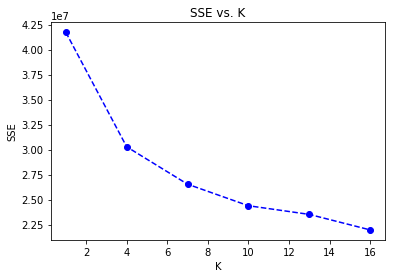

In [79]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center,random_state=99)
    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    return score

scores = []
centers = list(range(1,18,3))

for center in centers: 
    scores.append(get_kmeans_score(df_n_pca, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');


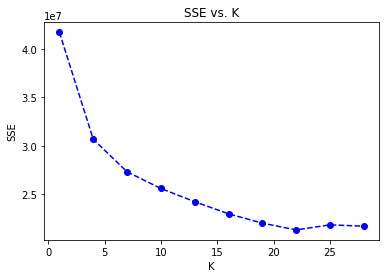

In [64]:
def get_minikmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = MiniBatchKMeans(n_clusters=center,random_state=99)
    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    return score

scores = []
centers = list(range(1,30,3))

for center in centers: 
    scores.append(get_minikmeans_score(df_n_pca, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [65]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=22,random_state=99)

# Then fit the model to your data using the fit method
gen_model = kmeans.fit(df_n_pca)
gen_predict = gen_model.predict(df_n_pca)


In [66]:
print(gen_model.cluster_centers_[1])
print(gen_model.labels_.shape)
print(gen_predict.shape)


[ -8.55569675e-01  -5.08959059e+00   1.98536401e+00  -8.48372408e-02
   9.48134305e-03   4.42502854e-02  -1.43158664e-01   1.05257073e-02
   1.71503173e-01  -2.92280934e-01   3.11606728e-01  -3.76350229e-01
   1.59829986e-02  -4.20045110e-03   7.41818041e-02   3.75598167e-02
  -1.09939899e-01  -6.09377227e-02  -1.15421733e-01   7.60079225e-02
  -1.06386402e-01   1.01809105e-01  -5.28070848e-02  -1.57776233e-01
   9.52091206e-02  -4.35974005e-01]
(774743,)
(774743,)


### Discussion 3.1: Apply Clustering to General Population

After plotting the scores for 1-30 clusters.The scores(distance between centre and the points mean square error) rate of change slightly increased after 22 clusters.
Also we could find sharp elbow point in above plot at 22 clusters.So, 22nd cluster would be a better option for this data.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [67]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv",sep=";")

In [68]:
#customer_clean_scaled = clean_scaled_data(customers)
customer_clean,cust_more_miss_data = clean_data(customers)

Columns to remove : ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
Shape after dropping more missing data cols: (191652, 79)
Shape after dropping multi-cols:  (136159, 65)
Shape of clean data : (136159, 63)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,GEN_BY_DEC,WEALTH,LIFE_STAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,0,2,1.0,3.0
1,4.0,2,5,1,5,1,4,4,1,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,0,2,3.0,4.0
2,4.0,1,5,1,5,2,1,2,0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1,1,2.0,4.0
3,3.0,1,3,1,4,4,5,2,0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,1,4,4.0,1.0
4,3.0,1,5,1,5,1,2,3,1,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,0,2,3.0,4.0


In [69]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

df_customer_trans = imputer.transform(customer_clean)
df_customer_trans = pd.DataFrame(df_customer_trans,columns = customer_clean.columns)
display(df_customer_trans.head())

df_customer_scaled = scaler.transform(df_customer_trans)
df_customer_scaled = pd.DataFrame(df_customer_scaled,columns=df_customer_trans.columns)
display(df_customer_scaled.head())


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,GEN_BY_DEC,WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,0.0,2.0,1.0,3.0
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,0.0,2.0,3.0,4.0
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
3,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,1.0,4.0,4.0,1.0
4,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,0.0,2.0,3.0,4.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,GEN_BY_DEC,WEALTH,LIFE_STAGE
0,1.180995,-1.043381,1.415239,-1.151076,1.133590,-1.247929,-0.454293,-0.818216,1.882757,-1.637628,...,-0.953065,1.435587,1.467394,-2.187068,-1.439172,-1.533403,-1.882757,-1.624552,-1.556065,0.092492
1,1.180995,0.958422,1.415239,-1.151076,1.133590,-1.247929,0.981043,0.612067,1.882757,-0.315096,...,0.422301,-0.625000,-1.243313,-0.179238,-0.132956,-0.058229,-1.882757,-1.624552,-0.192596,0.763676
2,1.180995,-1.043381,1.415239,-1.151076,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.315096,...,-0.953065,-0.625000,0.563825,-2.187068,-1.003767,-1.533403,0.531136,-2.307192,-0.874330,0.763676
3,0.198811,-1.043381,-0.036773,-1.151076,0.407498,0.789423,1.698711,-0.818216,-0.531136,1.007436,...,0.422301,-0.625000,-0.339744,-0.179238,-0.132956,-1.533403,0.531136,-0.259273,0.489138,-1.249876
4,0.198811,-1.043381,1.415239,-1.151076,1.133590,-1.247929,-0.454293,-0.103075,1.882757,1.007436,...,0.422301,1.435587,1.467394,-0.179238,0.737855,1.416945,-1.882757,-1.624552,-0.192596,0.763676


In [70]:
df_customer_pca = pca.transform(df_customer_scaled)
customer_predict = gen_model.predict(df_customer_pca)

In [71]:
print(customer_predict)
print(customer_predict.shape)

[ 9 14  3 ...,  9  7  3]
(136159,)


In [72]:
print(df_customer_pca.shape)

(136159, 26)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

(23, 2)

Text(0,0.5,'count in %')

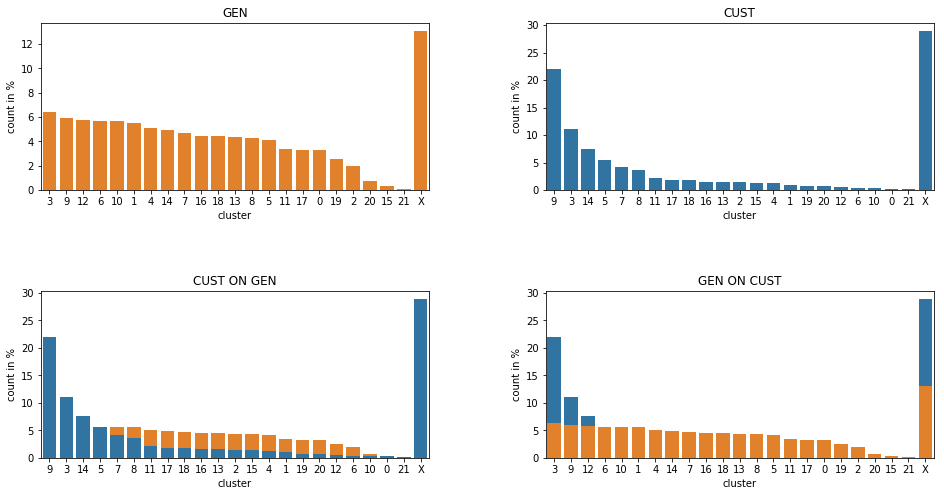

In [74]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

general_predict = pd.Series(gen_predict) 

gen = pd.DataFrame(general_predict.value_counts())
gen.loc['X'] = gen_more_miss_data.shape[0]
gen = gen.reset_index()
gen.columns =['cluster','count']
gen['count'] = (gen['count']/gen['count'].sum())* 100

display(gen.shape)
#display(gen)

cust_predict = pd.Series(customer_predict)
cust = pd.DataFrame(cust_predict.value_counts())
cust.loc['X'] = cust_more_miss_data.shape[0]
cust = cust.reset_index()
cust.columns =['cluster','count']
cust['count'] = (cust['count']/cust['count'].sum())* 100
#display(cust)


fig = plt.figure(figsize=(16,8))
fig.subplots_adjust(wspace=.3,hspace=.6)

ax = plt.subplot(221) 
sns.barplot(x='cluster',y='count',data=gen,ax=ax,color=sns.color_palette()[1])
ax.set_title("GEN")
ax.set_ylabel('count in %')

ax2 = plt.subplot(222) 
sns.barplot(x='cluster',y='count',data=cust,ax=ax2,color=sns.color_palette()[0])
ax2.set_title("CUST")
ax2.set_ylabel('count in %')

ax3 = plt.subplot(223) 
sns.barplot(x='cluster',y='count',data=gen,ax=ax3,color=sns.color_palette()[1])
sns.barplot(x='cluster',y='count',data=cust,ax=ax3,color=sns.color_palette()[0])
ax3.set_title("CUST ON GEN")
ax3.set_ylabel('count in %')

ax4 = plt.subplot(224)
sns.barplot(x='cluster',y='count',data=cust,ax=ax4,color=sns.color_palette()[0])
sns.barplot(x='cluster',y='count',data=gen,ax=ax4,color=sns.color_palette()[1])
ax4.set_title("GEN ON CUST")
ax4.set_ylabel('count in %')


In [75]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
#Cluster 3,9,12 are overrepresented.And 3 has high difference 

display(gen_model.cluster_centers_[3].shape)
inv_pca = pca.inverse_transform(gen_model.cluster_centers_[1])
display(inv_pca.shape)
inv_scaler = scaler.inverse_transform(inv_pca)
display(inv_scaler.shape)
dat = pd.DataFrame(inv_scaler)
dat['column'] = df_customer_scaled.columns
display(dat)


(26,)

(63,)

(63,)

,0,column
0,1.719277,ALTERSKATEGORIE_GROB
1,0.960189,ANREDE_KZ
2,3.049120,FINANZ_MINIMALIST
3,4.096120,FINANZ_SPARER
4,2.160120,FINANZ_VORSORGER
5,3.894667,FINANZ_ANLEGER
6,4.014195,FINANZ_UNAUFFAELLIGER
7,2.328010,FINANZ_HAUSBAUER
8,0.324769,GREEN_AVANTGARDE
9,2.099028,HEALTH_TYP


In [76]:
print_cal_weights(pca,1,df_customer_scaled.columns)

PLZ8_ANTG3            0.2253
PLZ8_ANTG4            0.2175
WEALTH                0.2053
HH_EINKOMMEN_SCORE    0.2029
ORTSGR_KLS9           0.1961
Name: Dimension1, dtype: float64

KBA05_GBZ           -0.2158
KBA05_ANTG1         -0.2170
FINANZ_MINIMALIST   -0.2222
PLZ8_ANTG1          -0.2253
MOBI_REGIO          -0.2292
Name: Dimension1, dtype: float64

In [77]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
#Clusters are underrepresented
#display(gen_model.cluster_centers_[20])
# clusters 16,13,15,4,2,1,19,20 are underrepresented 
inv_pca = pca.inverse_transform(gen_model.cluster_centers_[20])
#display(inv_pca)
inv_scaler = scaler.inverse_transform(inv_pca)
#display(inv_scaler)
dat = pd.DataFrame(inv_scaler)
dat['column'] = df_customer_scaled.columns
display(dat)


,0,column
0,2.770705,ALTERSKATEGORIE_GROB
1,1.509874,ANREDE_KZ
2,3.107244,FINANZ_MINIMALIST
3,2.707769,FINANZ_SPARER
4,3.431349,FINANZ_VORSORGER
5,2.841506,FINANZ_ANLEGER
6,2.670484,FINANZ_UNAUFFAELLIGER
7,3.068615,FINANZ_HAUSBAUER
8,0.235310,GREEN_AVANTGARDE
9,2.211821,HEALTH_TYP


### Discussion 3.3: Compare Customer Data to Demographics Data

* Comparison has been made between Customer data and Demographics data by adding more missing data as cluster 'X'.
* After looking at the cluster plot Clusters 3,9,12  are relatively popular with mail-order company and other Clusters are quite unpopular.
* And if we observe cluster 3 after comparing with dictionary data, we can see all SEMIO(personality topology) averages 5-6(are low-very low affinity) and  it may belong to prosperous(as welath ~2.5) and life_stage(families with school children) high share of 6-10 and 10+ families living in PLZ8 region with average financial interest. And these are the people we have to target.
* And if we observe Cluster 20 an unpopular one, we can see all SEMIO(personality topology) averages 3-4(average affinity) and  it may belong to less affluent(as welath ~3.5) and life_stage(families with school children) and financial topology is 2-3 (high to average).

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.